<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In [10]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import time
import numpy as np
import matplotlib.pyplot as plt

In [11]:
%cd ../functions
from trajectory import Trajectory
from utils import simulate_data
from plotting import plot_phase, plot_t, plot_theta

/home/mffang/workspace/Trajectory/Poisson-regression/functions


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 20 16:00:15 2022

@author: fang

This file defines functions (guess_theta, update_theta_j, update_theta_j, get_logL) for two species Poisson model with L1 penalty. 
theta for each gene contains transcription rate of each states, u_0, s_0, beta, gamma.

"""

import numpy as np
from scipy.optimize import minimize


# global parameters: upper and lower limits for numerical stability
eps = 1e-10

def guess_theta(X,n_states):
    p = X.shape[1]
    theta = np.zeros((p,n_states+4))
    theta[:,0:-3]=np.mean(X[:,:,0],axis=0)[:,None]
    theta[:,-3]=np.mean(X[:,:,1],axis=0)
    theta[:,-2]=1
    theta[:,-1] = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
    return theta



def get_y_a(theta, t, tau):
    # theta: a_1, ..., a_K, u_0, s_0, beta, gamma
    # t: len m
    # tau: len K+1
    # return m * p * 2
    K = len(tau)-1 # number of states
    a = theta[0:K]
    beta = theta[-2]
    gamma = theta[-1]

    y1_0 = theta[-4]
    y2_0 = theta[-3]

    c = beta/(beta-gamma+eps)
    d = beta**2/((beta-gamma)*gamma+eps)
    y_0 = y2_0 + c*y1_0
    a_ = d*a
    t = t
    m = len(t)
  
    I = np.ones((K+1,m),dtype=bool)

    # nascent
    y1=y1_0*np.exp(-t*beta)
    y=y_0*np.exp(-t*gamma)   
    for k in range(1,K+1):
        I[k] = np.squeeze(t > tau[k])
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        y1 = y1 + a[k-1] * (np.exp(- (I[k] *(t-tau[k]))*beta)- np.exp(-(I[k]*(t-tau[k-1]))*beta )) \
          + a[k-1] * (1 - np.exp(- (idx *(t-tau[k-1]))*beta ) )
        y = y + a_[k-1] * (np.exp(-(I[k] * (t-tau[k]))*gamma)- np.exp(-(I[k] * (t-tau[k-1]))*gamma )) \
          +  a_[k-1] * (1 - np.exp(-(idx*(t-tau[k-1]))*gamma) )

    Y = np.zeros((m,2))
    Y[:,0] = y1
    Y[:,1] = y-c*y1
    
    Y[Y<0]=0
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y

def get_y_a_jac(theta, t, tau):
    # theta: a_1, ..., a_K, u_0, s_0, beta, gamma
    # t: len m
    # tau: len K+1
    # return m * p * 2
    K = len(tau)-1 # number of states
    a = theta[0:K]
    y1_0 = theta[-4]
    y2_0 = theta[-3]
    beta = theta[-2]
    gamma = theta[-1]

    c = beta/(beta-gamma+eps) 
    dc_dbeta = - gamma/((beta-gamma)**2+eps)
    dc_dgamma = beta/((beta-gamma)**2+eps)
    d = beta**2/((beta-gamma)*gamma+eps)
    y_0 = y2_0 + c*y1_0
    a_ = d*a
    da__dbeta = a * (beta**2-2*beta*gamma)/((beta-gamma)**2*gamma+eps)
    da__dgamma = a * (-beta**3+2*beta**2*gamma)/((beta-gamma)**2*gamma**2+eps)

    
    m = len(t)
    I = np.ones((K+1,m),dtype=bool)
    dY_dtheta = np.zeros((m,2,len(theta)))
    
    # nascent
    y1=y1_0*np.exp(-t*beta)
    y=y_0*np.exp(-t*gamma)
    dY_dtheta[:,0,-4] = np.exp(-t*beta)
    dY_dtheta[:,1,-3] = np.exp(-t*gamma)   
    dY_dtheta[:,1,-4] = c * (dY_dtheta[:,1,-3] - dY_dtheta[:,0,-4])
    
    dY_dtheta[:,0,-2] = - t * y1_0 * np.exp(-t*beta)
    dY_dtheta[:,1,-2] = dc_dbeta * y1_0 * np.exp(-t*gamma)
    dY_dtheta[:,1,-1] = dc_dgamma * y1_0 * np.exp(-t*gamma)  - t * y_0 * np.exp(-t*gamma)
    
    for k in range(1,K+1):
        I[k] = np.squeeze(t > tau[k])
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        
        y1_a_k_coef = np.exp(- (I[k] *(t-tau[k]))*beta) - np.exp(-(I[k] * (t-tau[k-1])) * beta ) + 1 - np.exp(- (idx * (t-tau[k-1]))*beta ) 
        y_a_k_coef = np.exp(- (I[k] * (t-tau[k]))*gamma) - np.exp(-(I[k] * (t-tau[k-1])) * gamma) + 1 - np.exp(- (idx * (t-tau[k-1]))*gamma)

        y1 += a[k-1] *  y1_a_k_coef
        y += a_[k-1] * y_a_k_coef
        
        dY_dtheta[:,0,k-1] = y1_a_k_coef
        dY_dtheta[:,1,k-1] = d * y_a_k_coef
        
        dy1_a_k_coef_dbeta = - (t-tau[k]) * I[k] * np.exp(- (I[k] * (t-tau[k])) * beta) + (t-tau[k-1]) * I[k] * np.exp(-(I[k] * (t-tau[k-1])) * beta ) +  idx * (t-tau[k-1]) * np.exp(- (idx * (t-tau[k-1])) * beta)
        dy_a_k_coef_dgamma = - (t-tau[k]) * I[k] * np.exp(- (I[k] * (t-tau[k])) * gamma) + (t-tau[k-1]) * I[k] * np.exp(-(I[k] * (t-tau[k-1])) * gamma ) + idx * (t-tau[k-1]) * np.exp(- (idx * (t-tau[k-1])) * gamma) 
        
        dY_dtheta[:,0,-2] += a[k-1] * dy1_a_k_coef_dbeta
        dY_dtheta[:,1,-2] += da__dbeta[k-1] * y_a_k_coef
        dY_dtheta[:,1,-1] += da__dgamma[k-1] * y_a_k_coef + a_[k-1] * dy_a_k_coef_dgamma
        
    Y = np.zeros((m,2))
    Y[:,0] = y1
    Y[:,1] = y-c*y1
    
    dY_dtheta[:,1,0:K] -= c * dY_dtheta[:,0,0:K]
    dY_dtheta[:,1,-2] -=  c * dY_dtheta[:,0,-2] + dc_dbeta * y1
    dY_dtheta[:,1,-1] -= dc_dgamma * y1
    
    Y[Y<0]=0
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
        
    if np.sum(np.isnan(dY_dtheta)) != 0:
        raise ValueError("Nan in dY_dtheta")
        
    return Y, dY_dtheta


def get_Y(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
        print(np.shape(theta)[1], K+4)
        raise TypeError("wrong parameters lengths")
    a = theta[:,0:K].T
    beta = theta[:,-2].reshape((1,-1))
    gamma = theta[:,-1].reshape((1,-1))

    y1_0 = theta[:,-4].reshape((1,-1))
    y2_0 = theta[:,-3].reshape((1,-1))

    c = beta/(beta-gamma+eps)
    d = beta**2/((beta-gamma)*gamma+eps)
    y_0 = y2_0 + c*y1_0
    a_ = d*a
    t = t.reshape(-1,1)
    m = len(t)
  
    I = np.ones((K+1,m),dtype=bool)

    # nascent
    y1=y1_0*np.exp(-t@beta)
    for k in range(1,K+1):
        I[k] = np.squeeze(t > tau[k])
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        y1 = y1 + a[None,k-1] * (np.exp(- (I[k,:,None] *(t-tau[k]))@beta)- np.exp(-(I[k,:,None]*(t-tau[k-1]))@beta )) \
          + a[None,k-1] * (1 - np.exp(- (idx[:,None] *(t-tau[k-1]))@beta ) )
    
    if np.sum(np.isnan(y1)) != 0:
        raise ValueError("Nan in y1")
    # mature + c * nascent 
    y=y_0*np.exp(-t@gamma)    
    for k in range(1,K+1):
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        y = y + a_[None,k-1] * (np.exp(-(I[k,:,None] * (t-tau[k]))@gamma)- np.exp(-(I[k,:,None] * (t-tau[k-1]))@gamma )) \
          +  a_[None,k-1] * (1 - np.exp(-(idx[:,None]*(t-tau[k-1]))@gamma) )

    Y = np.zeros((m,p,2))
    Y[:,:,0] = y1
    Y[:,:,1] = y-c*y1
    
    Y[Y<0]=0
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y


def get_Y_a_old(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
        raise TypeError("wrong parameters lengths")
    a = theta[:,0:K]
    beta = theta[:,-2]
    gamma = theta[:,-1]
    y1_0 = theta[:,-4]
    y2_0 = theta[:,-3]
    t = t.reshape(-1,1)
    m = len(t)
    I = np.ones((K+1,m),dtype=bool)
    
    # nascent
    y1=np.zeros((m,p))
    y1=y1+y1_0[None,:]*np.exp(-beta[None,:]*t)   
    for k in range(1,K+1):
        I[k] = np.squeeze(t > tau[k])
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        y1[I[k]] = y1[I[k]] + a[None,:,k-1] * (np.exp(- beta[None,:]*(t[I[k]]-tau[k]))- np.exp(-beta[None,:]* (t[I[k]]-tau[k-1])) ) 
        y1[idx] = y1[idx] + a[None,:,k-1] * (1 - np.exp(- beta[None,:] *(t[idx]-tau[k-1]))) 

    if np.sum(np.isnan(y1)) != 0:
        raise ValueError("Nan in y1")
    Y =np.zeros((m,p,2))
    Y[:,:,0] = y1
    
    # mature + c * nascent 
    ## nondegenrate cases
    nondegenerate = np.abs(beta-gamma)>eps # indices of genes having similar gamma and beta
    if np.sum(nondegenerate)>0:
        y =np.zeros((m,np.sum(nondegenerate)))
        beta_, gamma_ = beta[nondegenerate], gamma[nondegenerate]
        c = beta_/(beta_-gamma_)
        d = beta_**2/((beta_-gamma_)*gamma_)
        y_0 = y2_0[nondegenerate] + c*y1_0[nondegenerate]
        a_ = d[:,None]*a[nondegenerate,:]

        y=y+y_0[None,:]*np.exp(-gamma_[None,:]*t)    
        for k in range(1,K+1):
            idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
            y[I[k]] = y[I[k]] + a_[None,:,k-1] * (np.exp(-gamma_[None,:] * (t[I[k]]-tau[k]))- np.exp(-gamma_[None,:]*(t[I[k]]-tau[k-1])) )
            y[idx] = y[idx] +  a_[None,:,k-1] * (1 - np.exp(-gamma_[None,:]*(t[idx]-tau[k-1]))) 

        if np.sum(np.isnan(y)) != 0:
            raise ValueError("Nan in y")

        Y[:,nondegenerate,1] = y-c*y1[:,nondegenerate]
    
    ## nondegenrate cases
    degenerate = ~nondegenerate
    if np.sum(degenerate)>0:
        y = np.zeros((m,np.sum(degenerate)))
        y = y + y1_0[None,degenerate]*beta[None,degenerate]*t*np.exp(-beta[None,degenerate]*t) + y2_0[None,degenerate]*np.exp(-gamma[None,degenerate]*t) 
        for k in range(1,K+1):
            idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k with a[k-1]
            y[I[k]] = y[I[k]] + a[None,degenerate,k-1]*beta[None,degenerate]*((t[I[k]]-tau[k])*(np.exp(- beta[None,degenerate]*(t[I[k]]-tau[k])) - np.exp(- beta[None,degenerate]*(t[I[k]]-tau[k-1]))))    
            y[I[k]] = y[I[k]] + a[None,degenerate,k-1] * (np.exp(- beta[None,degenerate]*(t[I[k]]-tau[k])) - np.exp(- beta[None,degenerate] *(t[I[k]]-tau[k-1])) \
                                             - beta[None,degenerate] *(tau[k]-tau[k-1])*np.exp(- beta[None,degenerate] *(t[I[k]]-tau[k-1])))
            y[idx] = y[idx] + a[None,degenerate,k-1] * (1 - np.exp(-beta[None,degenerate]*(t[idx]-tau[k-1]))\
                                             - beta[None,degenerate] *(t[idx]-tau[k-1])*np.exp(- beta[None,degenerate]*(t[idx]-tau[k-1]))) 
        Y[:,degenerate,1] = y
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y

   
def neglogL_a(theta, x_weighted, marginal_weight, t, tau, topo, penalty=0):
    # theta: length K+4
    # x: n*2
    # Q: n*L*m
    # t: len m
    # tau: len K+1
    logL = 0
    for l in range(len(topo)):
        theta_l = np.concatenate((theta[topo[l]], theta[-4:]))
        Y = get_y_a(theta_l,t,tau) # m*2
        logL += np.sum( x_weighted[l] * np.log(eps + Y) - marginal_weight[l]*Y )
        
    for lineage in topo:
        logL -= penalty*np.abs(theta[lineage[0]]-theta[-4])
        if len(lineage)>1:
            for s in range(1,len(lineage)):
                logL -= penalty*np.abs(theta[lineage[s]]-theta[lineage[s-1]])
        #logL -= np.abs(theta[-3]*theta[-1]/theta[-2]-theta[-4])
    return - logL


def neglogL_a_jac(theta, x_weighted, marginal_weight, t, tau, topo):
    # theta: length K+4
    # x: n*2
    # Q: n*L*m
    # t: len m
    # tau: len K+1
    jac = np.zeros_like(theta)
    for l in range(len(topo)):
        theta_idx = np.append(topo[l],[-4,-3,-2,-1])
        theta_l = theta[theta_idx]
        Y, dY_dtheta = get_y_a_jac(theta_l,t,tau) # m*2*len(theta)
        coef =  x_weighted[l] / (eps + Y) - marginal_weight[l]
        jac[theta_idx] += np.sum( coef [:,:,None] * dY_dtheta, axis=(0,1))
    
    return - jac

def get_logL(X,theta,t,tau,topo):
    L=len(topo)
    m=len(t)
    p=len(theta)
    Y = np.zeros((L,m,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-4:]), axis=1)
        Y[l] = get_Y(theta_l,t,tau) # m*p*2
        
    logL = np.tensordot(X, np.log(eps + Y), axes=([-2,-1],[-2,-1])) # logL:n*L*m
    logL -= np.sum(Y,axis=(-2,-1))
    #logX = np.sum(gammaln(X+1),axis=(-2,-1),keepdims=True)
    #logL -= logX
    return logL


def update_theta_j(theta0, x, Q, t, tau, topo, bnd=1000, bnd_beta=100, miter=1000):
    """
    with jac

    Parameters
    ----------
    theta0 : TYPE
        DESCRIPTION.
    x : TYPE
        DESCRIPTION.
    Q : TYPE
        DESCRIPTION.
    t : TYPE
        DESCRIPTION.
    tau : TYPE
        DESCRIPTION.
    topo : TYPE
        DESCRIPTION.
    bnd : TYPE, optional
        DESCRIPTION. The default is 1000.
    bnd_beta : TYPE, optional
        DESCRIPTION. The default is 100.
    miter : TYPE, optional
        DESCRIPTION. The default is 1000.

    Returns
    -------
    TYPE
        DESCRIPTION.

    """
    bound = [[-bnd,bnd]]*len(theta0)
    bound[-2:] = [[1/bnd_beta,bnd_beta]]*2
    
    n,L,m = Q.shape
    x_weighted = np.zeros((L,m,2))
    marginal_weight = np.zeros((L,m,1))
    for l in range(len(topo)):
        weight_l = Q[:,l,:] #n*m
        x_weighted[l] = weight_l.T@x # m*2 = m*n @ n*2
        marginal_weight[l] =  weight_l.sum(axis=0)[:,None] # m*1
    
    res = minimize(fun=neglogL_a, x0=theta0, args=(x_weighted,marginal_weight,t,tau,topo), method = 'L-BFGS-B' , jac = None, bounds=bound, options={'maxiter': miter,'disp': False}) 
    return res.x

def update_nested_theta_j(theta0, x, Q, t, tau, topo, restrictions, bnd=1000, bnd_beta=100, miter=1000):
    # define a new neglogL inside with fewer parameters
    redundant, blanket = restrictions # 1,0 => a[1] = a[0], -3, -4 => s_0 = u_0*beta/gamma, 0,-4 => a[0] = u_0
    if len(redundant) > len(theta0) - 4:
        theta = np.ones(len(theta0))*np.mean(x[:,0])
        theta[-3]=np.mean(x[:,1])
        theta[-2]=1
        theta[-1] = theta[-4]/theta[-3]
        
    else:
        redundant_mask = np.zeros(len(theta0), dtype=bool)
        redundant_mask[redundant] = True
        custom_theta0 = theta0[~redundant_mask]  
        bound = [[0,bnd]]*len(custom_theta0)
        bound[-2:] = [[1/bnd_beta,bnd_beta]]*2
        
        n,L,m = Q.shape
        x_weighted = np.zeros((L,m,2))
        marginal_weight = np.zeros((L,m,1))
        for l in range(len(topo)):
            weight_l = Q[:,l,:] #n*m
            x_weighted[l] = weight_l.T@x # m*2
            marginal_weight[l] =  weight_l.sum(axis=0)[:,None] # m*1
     
        def custom_neglogL(custom_theta, x_weighted, marginal_weight, t, tau, topo):
            theta = np.zeros(len(theta0))
            theta[~redundant_mask] = custom_theta
            theta[redundant] = theta[blanket]
            if -3 in redundant:
                theta[-3] = theta[-4]*theta[-2]/theta[-1]
                
            return neglogL_a(theta, x_weighted, marginal_weight, t, tau, topo)
            
       
        res = minimize(fun=custom_neglogL, x0=custom_theta0, args=(x_weighted,marginal_weight,t,tau,topo), method = 'L-BFGS-B' , jac = None, bounds=bound, options={'maxiter': miter,'disp': False}) 
        theta = np.zeros(len(theta0))
        theta[~redundant_mask] = res.x
        theta[redundant] = theta[blanket]
        if -3 in redundant:
            theta[-3] = theta[-4]*theta[-2]/theta[-1]
            
    return theta

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 23 22:22:42 2022

@author: fang
"""
import itertools
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from scipy.special import logsumexp
#from basic import guess_theta, get_logL, update_theta_j, update_nested_theta_j
    
eps = 1e-10

def get_AIC(L,n,k):
    return -2*(L-k/n)


class Trajectory:
    """
    Representation of a trajectory model probability distribution.
    
    
    Attributes
    ----------
    topo: 2D np.darray
    tau:     
    """

    def __init__(self, topo, tau):
        self.topo=topo
        self.tau=tau
        self.L=len(topo)
        self.n_states=len(set(topo.flatten()))
        self.model_restrictions=None
        return None
    
    def _set_m(self,m):
        self.m=m
        self.t=np.linspace(self.tau[0],self.tau[-1],m)
    
    def _get_theta(self):
        return self.theta.copy()
    
    def _initialize_theta(self, X):
        self.theta=guess_theta(X,self.n_states)
        return 
    
    def _initialize_Q(self, n):
        Q=np.random.uniform(0,1,size=(n,self.L,self.m))
        Q=Q/Q.sum(axis=(-2,-1),keepdims=True)
        return Q

    def update_theta(self,X,Q,gene_idx=None,parallel=False,n_threads=1,bnd=1000,bnd_beta=100,miter=10000):
        """
        Update theta for each gene in gene_idx using update_theta_j function

        Parameters
        ----------
        X : TYPE
            DESCRIPTION.
        Q : TYPE
            DESCRIPTION.
        gene_idx : list/1d array, optional
            DESCRIPTION. The default is None.
        parallel : TYPE, optional
            DESCRIPTION. The default is False.
        n_threads : TYPE, optional
            DESCRIPTION. The default is 1.
        bnd : TYPE, optional
            DESCRIPTION. The default is 1000.
        bnd_beta : TYPE, optional
            DESCRIPTION. The default is 100.
        miter : TYPE, optional
            DESCRIPTION. The default is 1000.

        Returns
        -------
        None.

        """
        p, n_theta = self.theta.shape
            
        if gene_idx is None:
            gene_idx = np.arange(p)
            
        if parallel is True:
            Input_args = []
            for j in gene_idx:
                Input_args.append((self.theta[j], X[:,j], Q, self.t, self.tau, self.topo, bnd, bnd_beta, miter))
            with Pool(n_threads) as pool:      
                new_theta = pool.starmap(update_theta_j, Input_args)
            new_theta = np.array(new_theta)
        else:
            new_theta = np.zeros((len(gene_idx),n_theta))
            for i,j in enumerate(gene_idx): 
                new_theta[i]=update_theta_j(self.theta[j], X[:,j], Q, self.t, self.tau, self.topo, bnd, bnd_beta,miter)
                
        self.theta[gene_idx] = new_theta
        return
    
    
    def update_nested_theta(self,X,Q,model_restrictions,parallel=False,n_threads=1,bnd=1000,bnd_beta=100,miter=10000):
        """
        Update theta for each gene with restriction defined in model_restrictions using update_nested_theta_j function
        
        Parameters
        ----------
        X : TYPE
            DESCRIPTION.
        Q : TYPE
            DESCRIPTION.
        nested_model : TYPE
            DESCRIPTION.
        parallel : TYPE, optional
            DESCRIPTION. The default is False.
        n_threads : TYPE, optional
            DESCRIPTION. The default is 1.
        theta0 : TYPE, optional
            DESCRIPTION. The default is None.
        bnd : TYPE, optional
            DESCRIPTION. The default is 1000.
        bnd_beta : TYPE, optional
            DESCRIPTION. The default is 100.
        miter : TYPE, optional
            DESCRIPTION. The default is 1000.

        Raises
        ------
        TypeError
            DESCRIPTION.

        Returns
        -------
        None.

        """
        
        p, n_theta = self.theta.shape

        gene_idx = np.array(list(model_restrictions.keys()))
        if parallel is True:
            Input_args = []           
            for j in gene_idx:
                Input_args.append((self.theta[j], X[:,j], Q, self.t, self.tau, self.topo, model_restrictions[j], bnd, bnd_beta, miter))                
            with Pool(n_threads) as pool:      
                new_theta = pool.starmap(update_nested_theta_j, Input_args)
            new_theta = np.array(new_theta)
            
        else:
            new_theta = np.zeros((len(gene_idx),n_theta))
            for i,j in enumerate(gene_idx):
                new_theta[i]=update_nested_theta_j(self.theta[j], X[:,j], Q, self.t, self.tau, self.topo, model_restrictions[j], bnd, bnd_beta, miter)
                
        self.theta[gene_idx] = new_theta
        return 


    def update_weight(self,X,beta=1):
        """
        calculate q with beta

        Parameters
        ----------
        X : TYPE
            DESCRIPTION.

        Raises
        ------
        ValueError
            DESCRIPTION.

        Returns
        -------
        Q : TYPE
            DESCRIPTION.
        lower_bound : TYPE
            DESCRIPTION.

        """
        if not hasattr(self, 'theta'):
            raise AttributeError("self.theta not defined")
            
        #n,p,s=np.shape(X)
        
        logl = get_logL(X,self.theta,self.t,self.tau,self.topo) # with size (n,self.L,self.m)
        
        #Y = np.zeros((self.L,self.m,p,2))
        #for l in range(self.L):
            #theta_l = np.concatenate((self.theta[:,self.topo[l]], self.theta[:,-4:]), axis=1)
            #Y[l] = get_Y(theta_l,self.t,self.tau) # m*p*2
            
        #logL =  np.sum(X[:,None,None,:,:] * np.log(Y[None,:]+eps) - Y[None,:], axis=(-2,-1)) # n*L*m*p*2 -> n*L*m
        #logl = np.tensordot(X, np.log(eps + Y),axes=([-2,-1],[-2,-1]))
        #logl -= np.sum(Y,axis = (-2,-1))
        
        logL = logl/beta
        #logL += np.log(self.prior_) where self.prior_ = 1/L/m
        #Q = softmax(logL, axis=(-2,-1))
        a = np.amax(logL,axis=(-2,-1))
        temp = np.exp(logL-a[:,None,None])
        temp_sum = temp.sum(axis=(-2,-1))
        Q = temp/temp_sum[:,None,None]
        if beta == 1:
            lower_bound = np.mean( np.log(temp_sum) + a )  - np.log(self.m) - np.log(self.L)
        else:
            lower_bound = np.mean(logsumexp(logl, axis=(-2,-1))) - np.log(self.m) - np.log(self.L)
        return Q, lower_bound
    
    def _fit(self, X, theta, epoch, tol, parallel, n_threads):
        """
        The method fits the model by iterating between E-step and M-step for at most `epoch` iterations.
        The warm start means that either a reasonable Q or theta is provided.
    

        Parameters
        ----------
        X : ndarray, shape (n, p, 2)
            n cells * p genes * 2 species data matrix.
        epoch : TYPE, optional
            DESCRIPTION. The default is 10.
        tol : TYPE, optional
            DESCRIPTION. The default is 0.01.
        parallel : TYPE, optional
            DESCRIPTION. The default is False.
        n_threads : TYPE, optional
            DESCRIPTION. The default is 1.

        Returns
        -------
        theta_hist : TYPE
            DESCRIPTION.
        weight_hist : TYPE
            DESCRIPTION.
        lower_bounds : TYPE
            DESCRIPTION.

        """
        
        n, p, _ = np.shape(X)
        lower_bound = -np.inf
        self.converged = False
        self.theta = theta.copy()
        for i in tqdm(range(epoch)):
            prev_lower_bound = lower_bound
            beta = 2 #epoch - i
            Q, lower_bound = self.update_weight(X, beta)
            self.update_theta(X,Q,parallel=parallel,n_threads=n_threads)
            
            ## check converged
            change = lower_bound - prev_lower_bound
            if abs(change) < tol:
                self.converged = True
                break
                
        return [Q, lower_bound]
    
    def fit_warm_start(self, X, Q=None, theta=None, epoch=10, tol=1e-4, parallel=False, n_threads=1):
        """
        The method fits the model by iterating between E-step and M-step for at most `epoch` iterations.
        The warm start means that either a reasonable Q or theta is provided.
    

        Parameters
        ----------
        X : ndarray, shape (n, p, 2)
            n cells * p genes * 2 species data matrix.
        Q : TYPE
            DESCRIPTION.
        epoch : TYPE, optional
            DESCRIPTION. The default is 10.
        tol : TYPE, optional
            DESCRIPTION. The default is 0.01.
        parallel : TYPE, optional
            DESCRIPTION. The default is False.
        n_threads : TYPE, optional
            DESCRIPTION. The default is 1.

        Returns
        -------
        theta_hist : TYPE
            DESCRIPTION.
        weight_hist : TYPE
            DESCRIPTION.
        lower_bounds : TYPE
            DESCRIPTION.

        """
        
        if theta is None:
            if Q is not None:
                n, L, m = Q.shape
                self._set_m(m)
                self._initialize_theta(X)
                self.update_theta(X,Q,parallel=parallel,n_threads=n_threads)
                theta = self.theta.copy()
            else:
                raise AssertionError("either theta or Q needs to be provided")
            
        #self.prior_ = np.ones_like(Q)/L/m

        #theta_hist=[] 
        #weight_hist=[]
        #lower_bounds=[]
        #theta_hist.append(self._get_theta())
        #weight_hist.append(Q.copy())
        
        return self._fit(X, theta, epoch, tol, parallel, n_threads)
    
    def fit_multi_init(self, X, m, n_init=3, epoch=10, tol=1e-4, parallel=False, n_threads=1, seed=42):
        """
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times

        Parameters
        ----------
        X : ndarray, shape (n, p, 2)
            DESCRIPTION.
        m : int
            DESCRIPTION.
        n_init : int, optional
            DESCRIPTION. The default is 3.
        epoch : int, optional
            DESCRIPTION. The default is 10.
        tol : float, optional
            DESCRIPTION. The default is 1e-3.
        parallel : bool, optional
            DESCRIPTION. The default is False.
        n_threads : int, optional
            DESCRIPTION. The default is 1.
        seed : int, optional
            DESCRIPTION. The default is 42.

        Returns
        -------
        list
            DESCRIPTION.

        """
        n, p, _ = np.shape(X)
     
        self._set_m(m)
        elbos = []
        thetas = []
        max_lower_bound = -np.inf
        
        np.random.seed(seed)
        for init in range(n_init):
            print("trial "+str(init+1))
            Q = self._initialize_Q(n)
            self._initialize_theta(X)
            self.update_theta(X,Q,parallel=parallel,n_threads=n_threads)
            theta0 = self.theta.copy()
            
            ## For each initialization, test all configurations
            for perm in itertools.permutations(range(self.n_states+1)):
                theta = theta0.copy()
                theta[:,:self.n_states+1] = theta0[:,np.array(perm)]
                
                Q, lower_bound = self._fit(X, theta, epoch, tol, parallel, n_threads)

                if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                    max_lower_bound = lower_bound
                    best_theta = self._get_theta()
                    best_Q = Q.copy()

                elbos.append(lower_bound)
                thetas.append(self._get_theta())
            
        self.theta = best_theta
        self.thetas = thetas
        return [best_Q, elbos]
    
    def fit_restrictions(self, X, Q, theta, model_restrictions, epoch=1, tol=1e-6, parallel=False, n_threads=1):
        """

        Parameters
        ----------
        X : TYPE
            DESCRIPTION.
        Q : TYPE
            DESCRIPTION.
        theta : TYPE
            DESCRIPTION.
        epoch : TYPE, optional
            DESCRIPTION. The default is 10.
        tol : TYPE, optional
            DESCRIPTION. The default is 1e-4.
        parallel : TYPE, optional
            DESCRIPTION. The default is False.
        n_threads : TYPE, optional
            DESCRIPTION. The default is 1.

        Returns
        -------
        list
            DESCRIPTION.

        """
                         
        n, p, _ = np.shape(X)
        gene_mask = np.ones(p,dtype=bool)
        gene_idx = np.arange(p)
        self.model_restrictions = model_restrictions
        gene_mask[np.array(list(self.model_restrictions.keys()))] = False
         
        self.converged = False
        lower_bound = -np.inf
        self.theta = theta.copy()
        m = Q.shape[-1]
        self._set_m(m)
        for i in range(epoch):
            prev_lower_bound = lower_bound
            Q, lower_bound = self.update_weight(X)
            self.update_theta(X,Q,gene_idx[gene_mask],parallel=parallel,n_threads=n_threads)      
            self.update_nested_theta(X,Q,self.model_restrictions,parallel=parallel,n_threads=n_threads)
            
           ## check converged
            change = lower_bound - prev_lower_bound
            if abs(change) < tol:
                self.converged = True
                break
                
        return [Q, lower_bound]                 
    

    
    def fit(self, X, Q=None, theta=None, model_restrictions=None, m=100, n_init=3, epoch=20, tol=1e-4, parallel=False, n_threads=1, seed=42):
        """
        

        Parameters
        ----------
        Q : TYPE, optional
            DESCRIPTION. The default is None.
        theta : TYPE, optional
            DESCRIPTION. The default is None.
        m : TYPE
            DESCRIPTION.
        n_init : TYPE, optional
            DESCRIPTION. The default is 3.
        epoch : TYPE, optional
            DESCRIPTION. The default is 10.
        tol : TYPE, optional
            DESCRIPTION. The default is 1e-4.
        parallel : TYPE, optional
            DESCRIPTION. The default is False.
        n_threads : TYPE, optional
            DESCRIPTION. The default is 1.
        seed : TYPE, optional
            DESCRIPTION. The default is 42.

        Returns
        -------
        None.

        """
        
        self._set_m(m)
        
        if Q is not None or theta is not None:
            print("run method fit_warm_start")
            res = self.fit_warm_start(X, Q=Q, theta=theta, epoch=epoch, tol=tol, parallel=parallel, n_threads=n_threads)
        else:
            print("run method fit_multi_init")
            res = self.fit_multi_init(X, m=m, n_init=n_init, epoch=epoch, tol=tol, parallel=parallel, n_threads=n_threads, seed=seed)
        
        if model_restrictions is not None:
            print("run method fit_restrictions")     
            res = self.fit_restrictions(X, res[0], self.theta, model_restrictions)
        
        return res
    
    def compute_lower_bound(self,X):
        """
        Compute the lower bound of marginal log likelihood log P(X|theta)

        Parameters
        ----------
        X : 3d array 
            Data

        Returns
        -------
        scalar
            lower bound value
        """
        #n,p,_=np.shape(X)
        #Y = np.zeros((self.L,self.m,p,2))
        #for l in range(self.L):
        #    theta_l = np.concatenate((self.theta[:,self.topo[l]], self.theta[:,-4:]), axis=1)
        #    Y[l] = get_Y(theta_l,self.t,self.tau) # m*p*2
        #logL =  np.sum(X[:,None,None,:,:] * np.log(Y[None,:]+eps) - Y[None,:], axis=(-2,-1)) # n*L*m*p*2 -> n*L*m
        #logL = np.tensordot(X, np.log(eps + Y), axes=([-2,-1],[-2,-1])) # logL:n*L*m
        #logL -= np.sum(Y,axis=(-2,-1))
        #logL += np.log(self.prior_) where self.prior_ = 1/L/m
        logL = get_logL(X,self.theta,self.t,self.tau,self.topo) # with size (n,self.L,self.m)
        return np.mean(logsumexp(a=logL, axis=(-2,-1)))-np.log(self.m)-np.log(self.L)

    
    def compute_AIC(self, X):
        """
        

        Parameters
        ----------
        X : TYPE
            DESCRIPTION.

        Returns
        -------
        None.

        """
        n, p, s = np.shape(X)
        
        self.k = self.theta.size
        
        if self.model_restrictions is not None:
            for j in list(self.model_restrictions.keys()):
                restrictions = self.model_restrictions[j]
                redundant, blanket = restrictions
                self.k -= len(redundant)
                if len(redundant) > self.n_states:
                    self.k -= 1

        logL = self.compute_lower_bound(X)

        return  get_AIC(logL,n,self.k)
    
    
    def compare_model(self, X, new_model, epoch=1, tol=1e-4, parallel=False, n_threads=1):
        """
        

        Parameters
        ----------
        nested_model : TYPE
            nested_model is a dict of restrictions. Keys are gene indices


        Returns
        -------
        accept: Bool
            Whether accept the nested model

        """
        if not hasattr(self, 'theta'):
            raise NameError("self.theta not defined. Run fit first")
        
        n, p, s = X.shape
        
        ##### Store the old model and compute relative AIC #####
        if not hasattr(self, 'ori_theta'):
            self.ori_theta = self.theta.copy()
            self.ori_AIC = self.compute_AIC(X)
            if self.model_restrictions is not None:
                self.ori_model = self.model_restrictions.copy()
            else:
                self.ori_model = None
            
        ##### update theta with restrictions #####
        Q , _ = self.update_weight(X)
            
        self.update_nested_theta(X,Q,new_model,parallel=parallel,n_threads=n_threads)
        
        ##### check AIC with old theta + new nested theta #####
        Q , logL = self.update_weight(X)
        k = p * (self.n_states+4)
        for j in list(new_model.keys()):
            restrictions = new_model[j]
            redundant, blanket = restrictions
            k -= len(redundant)
            if len(redundant) > self.n_states:
                k -= 1
                
        self.new_AIC = get_AIC(logL,n,k)
        
        ##### if the nested model is better, return True #####
        if self.new_AIC < self.ori_AIC:
            accept = True  
        
        ##### else, update the whole theta and check agian #####
        else:      
            ##### update all theta with new weight #####
            Q, logL = self.fit_restrictions(X, Q, self.theta, new_model, epoch, tol, parallel, n_threads)
            self.new_AIC = get_AIC(logL,n,k)
            
            if self.new_AIC < self.ori_AIC:
                accept = True  
            else:
                accept = False
                
        # return to original model
        self.new_theta = self.theta.copy()
        self.theta = self.ori_theta.copy() 
        if self.ori_model is not None:
            self.model_restrictions = self.ori_model.copy()
        else:
            self.model_restrictions = None
        return accept, self.new_AIC - self.ori_AIC


# Real data

**Load data and clusters information**

In [13]:
import scanpy

adata = scanpy.read('../data/hgForebrainGlut.loom')
adata.var_names_make_unique
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [14]:
total_UMI = adata.X.toarray().sum(axis=1)

In [15]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
print(Clusters)
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))

{0, 1, 2, 3, 4, 5, 6}


**Check housekeeping genes**

In [7]:
hk_genes=["RRN18S","ACTB","GAPDH","PGK1","PPIA","PRL13A","TBP","RPLP0","ARBP","B2M"]
idx=adata.var_names.isin(hk_genes)
genes=adata.var_names[idx]
print(genes)

Index(['RPLP0', 'GAPDH', 'B2M', 'TBP', 'ACTB', 'PPIA', 'PGK1'], dtype='object')


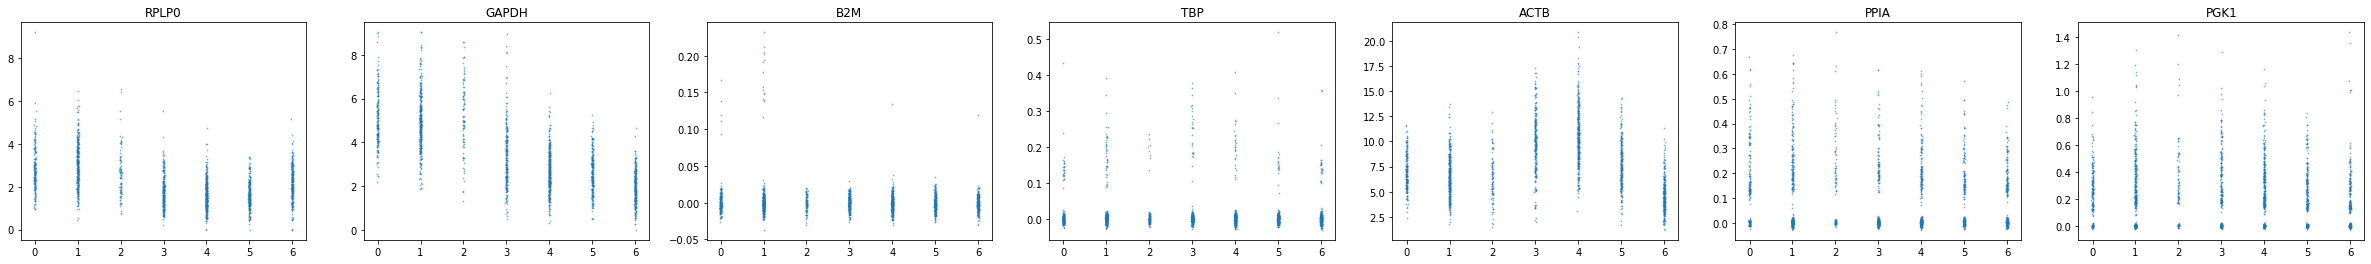

In [8]:
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
L=len(genes)
fig, axs=plt.subplots(1,L,figsize=(6*L,4))
for i in range(len(genes)):    
    s=S[:,i]
    axs[i].scatter(clusters+np.random.normal(0,0.01,np.shape(clusters)),s/total_UMI*1000+np.random.normal(0,0.01,np.shape(s)),s=0.5,alpha=0.5)
    axs[i].set_title(genes[i])

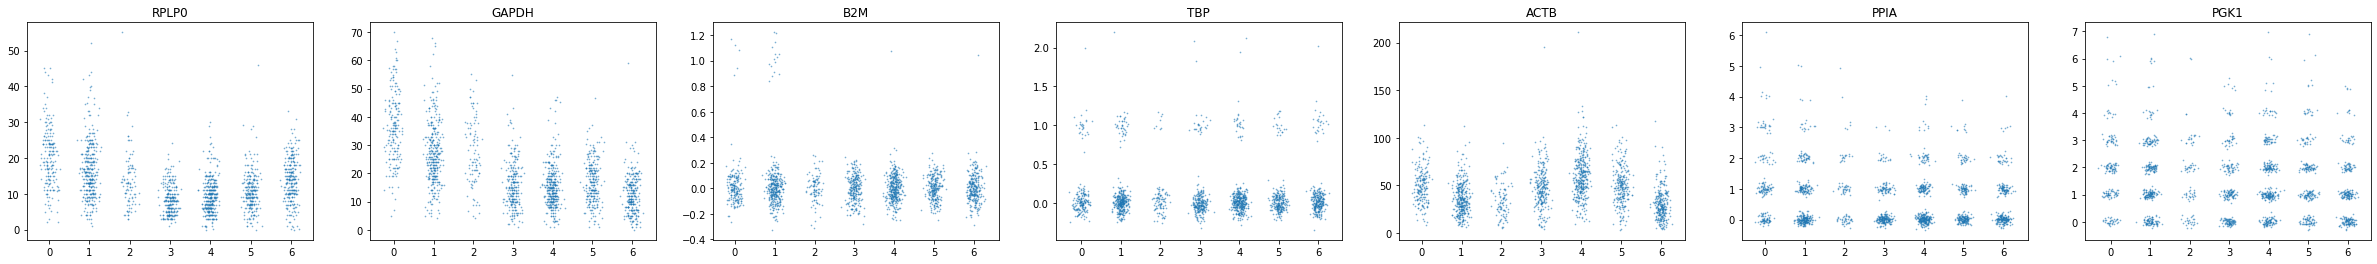

In [9]:
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
L=len(genes)
fig, axs=plt.subplots(1,L,figsize=(6*L,4))
for i in range(len(genes)):    
    s=S[:,i]
    axs[i].scatter(clusters+np.random.normal(0,0.1,np.shape(clusters)),s+np.random.normal(0,0.1,np.shape(s)),s=0.5,alpha=0.5)
    axs[i].set_title(genes[i])

**Initiate weight using clusters**

In [16]:
m=100
t_grids=np.linspace(0,1,m)
weight0 = np.ones((adata.n_obs,m))
for i in Clusters:
    idx = clusters.isin([i])
    weight0[idx,int(i*m/7):int((i+1)*m/7)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

## Inference with only marker genes

In [17]:
marker_genes=["SOX2","SLC17A7","EOMES","CLU","FBXO32",
       "UNC5D","SEZ6","RBFOX1","DCX","GRIA3",
       "STMN2", "FAM64A","ELAVL4","RNASEH2B"]
marker_idx=adata.var_names.isin(marker_genes)
gene_list=adata.var_names[marker_idx]
u=adata.layers["unspliced"][:,marker_idx].toarray()
s=adata.layers["spliced"][:,marker_idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

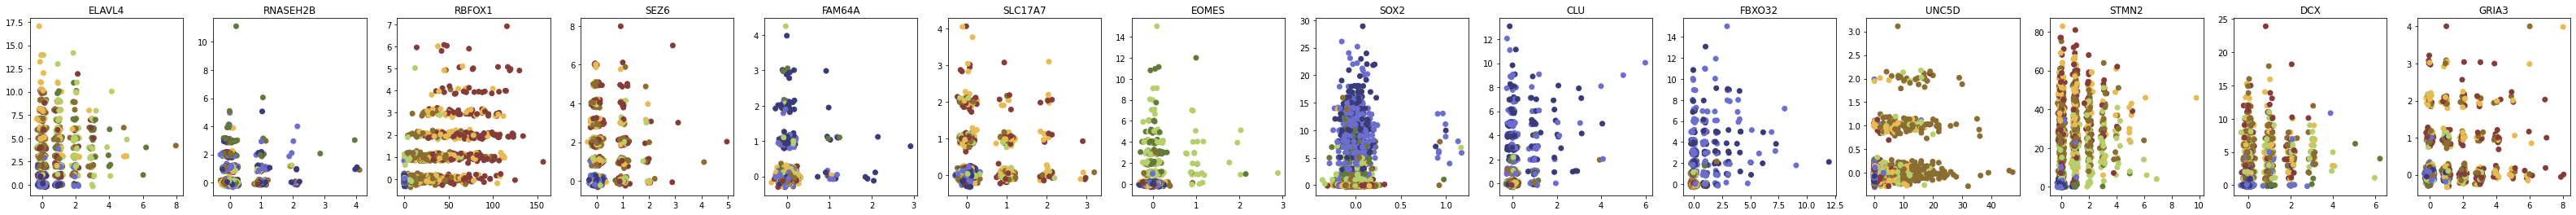

In [18]:
fig, ax = plt.subplots(1,14,figsize=(4*14,4))
for j in range(14):
    ax[j].scatter(X[:,j,0]+np.random.normal(scale=0.1,size=n),X[:,j,1]+np.random.normal(scale=0.1,size=n),c=colors20[np.mod(clusters, 20)]);
    ax[j].set_title(gene_list[j]);

### Without cluster information

In [19]:
tau=(0,0.5,1)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X, n_init=2, parallel=True, n_threads=10)

run method fit_multi_init
trial 1


KeyboardInterrupt: 

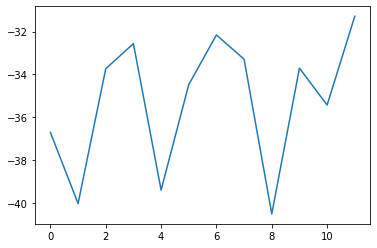

In [13]:
plt.plot(elbos)

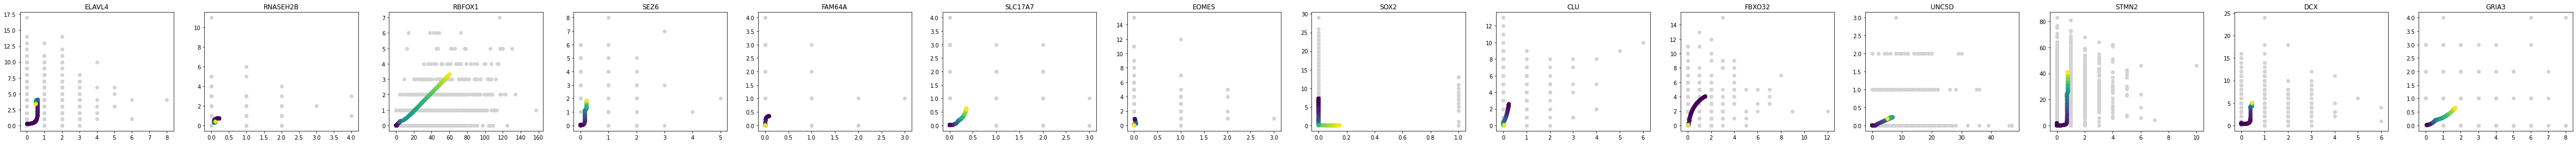

In [14]:
plot_phase(X, traj.theta, Q, topo, tau, gene_list)

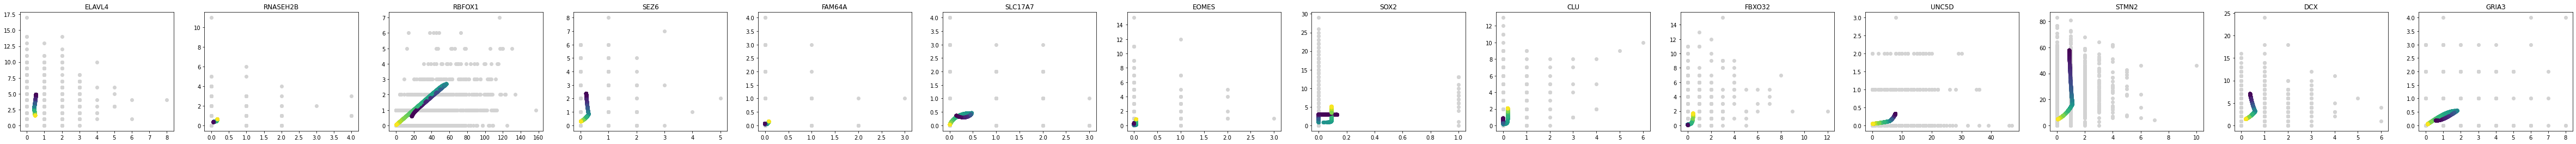

In [15]:
plot_phase(X,traj.thetas[0], Q, topo, tau, gene_list)

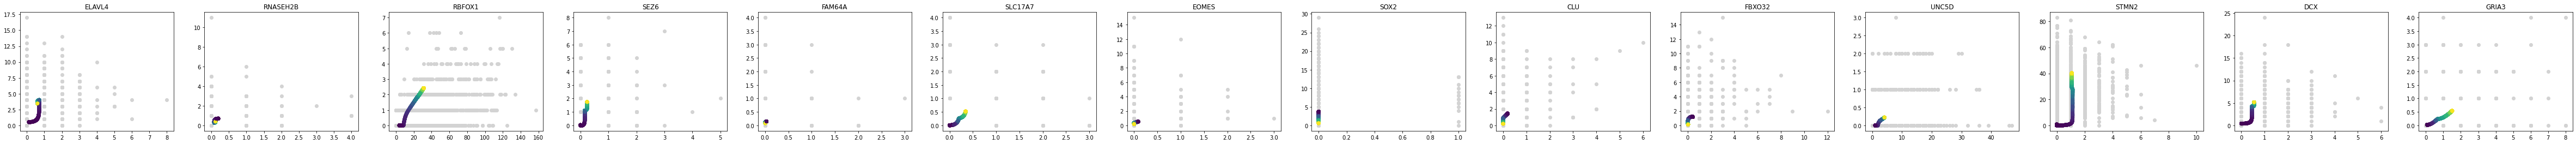

In [16]:
plot_phase(X,traj.thetas[1], Q, topo, tau, gene_list)

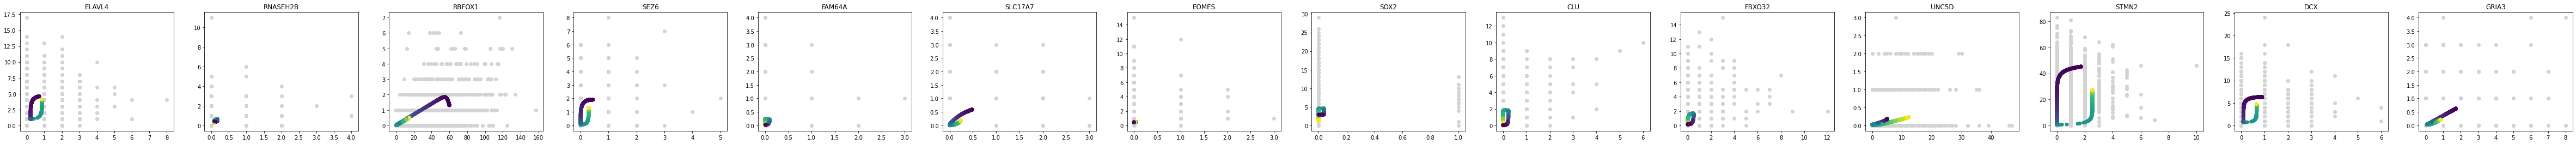

In [17]:
plot_phase(X,traj.thetas[2], Q, topo, tau, gene_list)

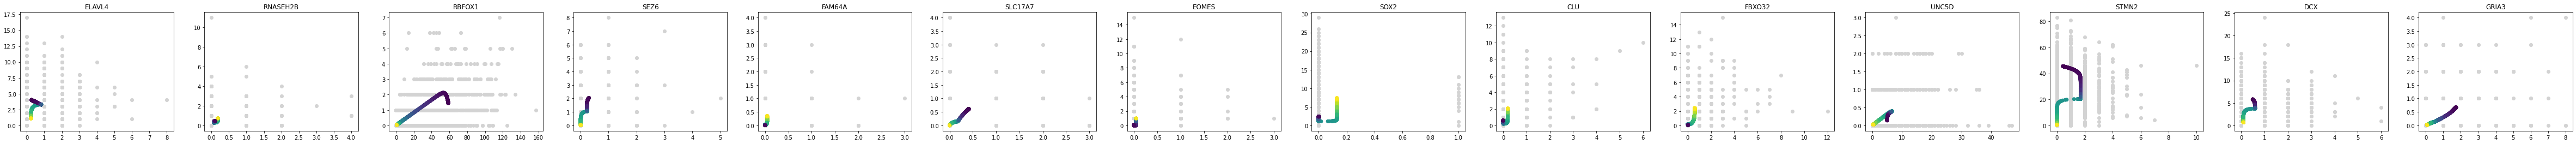

In [18]:
plot_phase(X,traj.thetas[3], Q, topo, tau, gene_list)

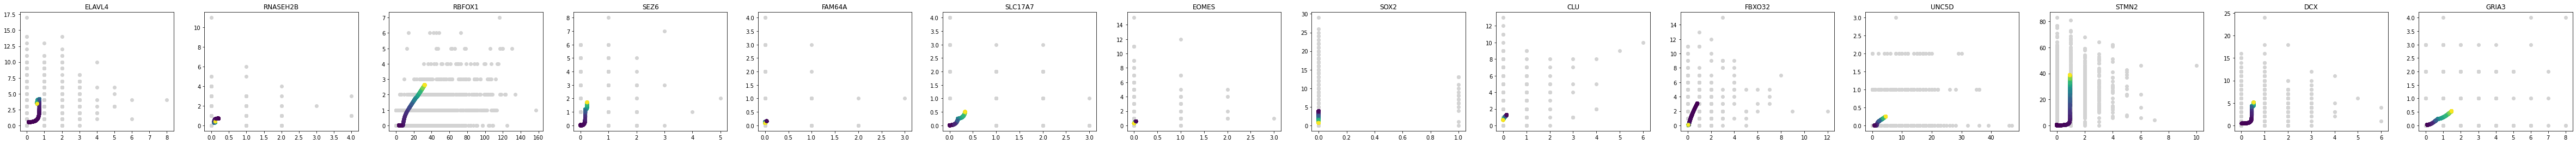

In [19]:
plot_phase(X,traj.thetas[4], Q, topo, tau, gene_list)

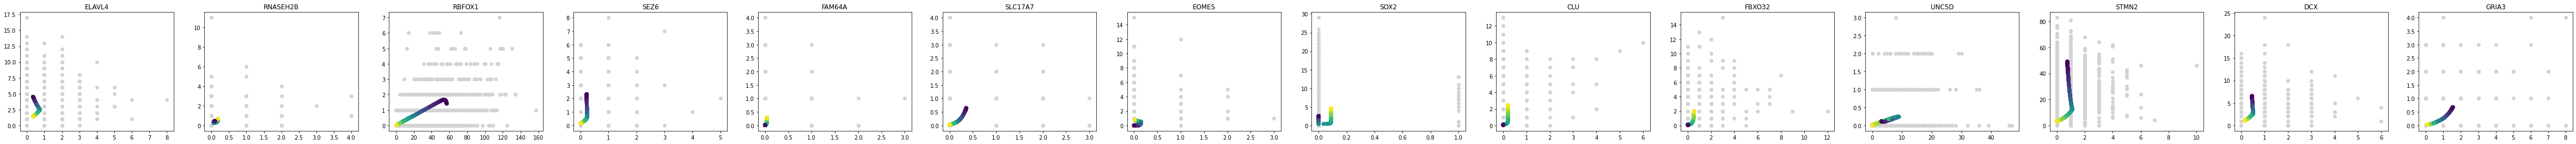

In [20]:
plot_phase(X,traj.thetas[5], Q, topo, tau, gene_list)

In [21]:
plot_phase(X,theta_hat_m,weight_m,tau,gene_list)

NameError: name 'theta_hat_m' is not defined

In [ ]:
plot_y(X,theta_hat_m,weight_m,tau,gene_list)

In [ ]:
plot_theta_hat(theta_hat_m, len(tau)-1, gene_list)

**Check cell size** 

In [ ]:
weight=Q[:,0]
m=np.shape(weight)[1]
h=np.linspace(0,1,m)
t_hat=np.sum(weight*h[None,:],axis=1)
plt.plot(t_hat,np.sum(adata.layers["spliced"],axis=1),'.');
plt.title("cell size");

# Use many non poisson genes

## Case 1

In [64]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

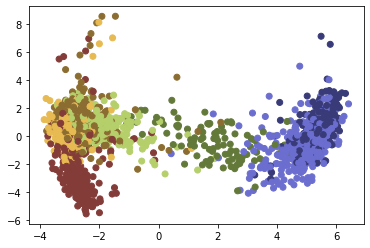

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+S/total_UMI[:,None]*1000))
plt.scatter(x[:,0],x[:,1],c=colors20[np.mod(clusters, 20)])

/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


225


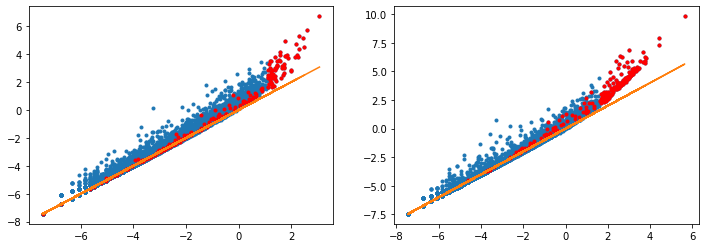

In [65]:
U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)

idx=( ((U_mu>3) &  ((U_var/U_mu-1)/U_mu>0.1)) | ((S_mu>5) & ((S_var/S_mu-1)/S_mu>0.1)) ) | marker_idx
print(np.sum(idx))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


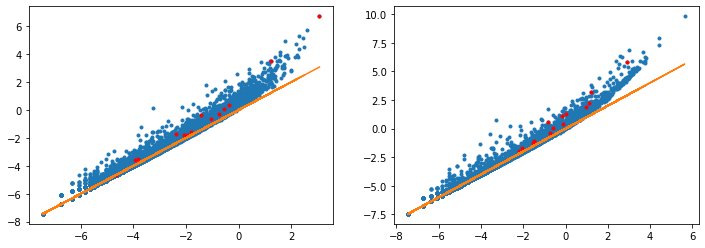

In [42]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[marker_idx]),np.log(U_var[marker_idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[marker_idx]),np.log(S_var[marker_idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

In [106]:
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s
X_hat = X / total_UMI[:,None,None] * np.mean(total_UMI)

In [107]:
plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx]

Index(['ELAVL4', 'RNASEH2B', 'RBFOX1', 'SEZ6', 'FAM64A', 'SLC17A7', 'EOMES',
       'SOX2', 'CLU', 'FBXO32', 'UNC5D', 'STMN2', 'DCX', 'GRIA3'],
      dtype='object')

In [122]:
tau=(0,0.5,1)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X_hat, n_init=5, parallel=True, n_threads=16, seed=63)

run method fit_multi_init
trial 1


 80%|████████  | 16/20 [00:17<00:04,  1.12s/it]

trial 2



100%|██████████| 20/20 [00:21<00:00,  1.09s/it]

trial 3



 65%|██████▌   | 13/20 [00:16<00:08,  1.28s/it]

trial 4



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

trial 5



 90%|█████████ | 18/20 [00:24<00:02,  1.37s/it]


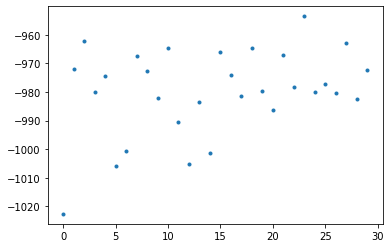

In [123]:
plt.plot(elbos,'.')

In [124]:
l1 = np.sum(np.abs(traj.theta[:,1]-traj.theta[:,0])**2 + np.abs(traj.theta[:,0]-traj.theta[:,-4])**2)
l1

4073471.4820731618

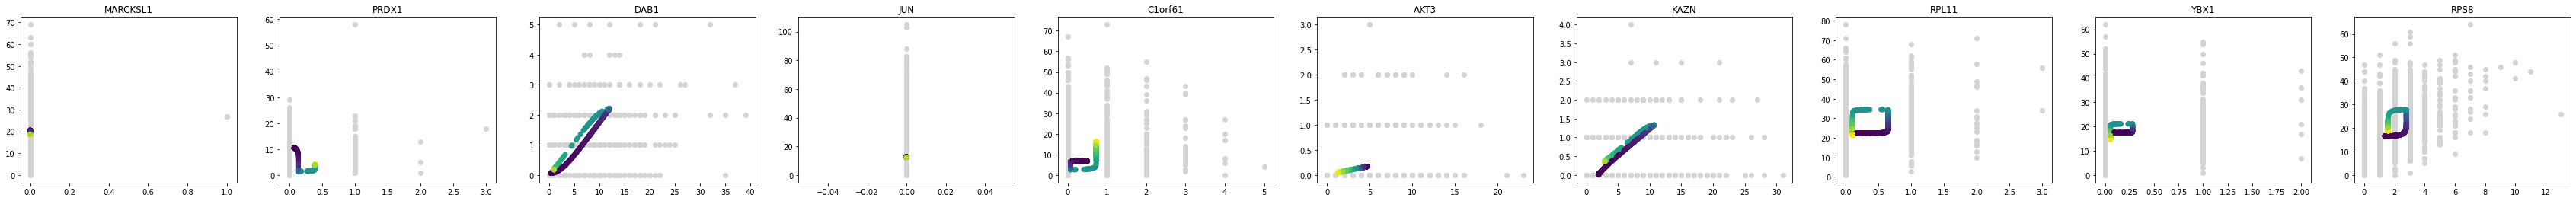

In [125]:
plot_phase(X[:,:10,:], traj.theta[:10,:], Q, topo, tau, gene_list[:10])

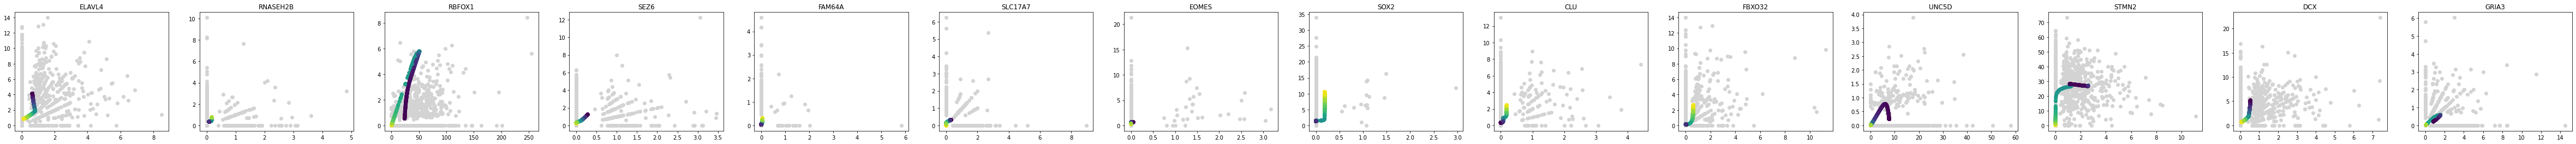

In [126]:
plot_phase(X_hat[:,plot_idx,:],traj.theta[plot_idx,:], Q, topo, tau, gene_list[plot_idx])

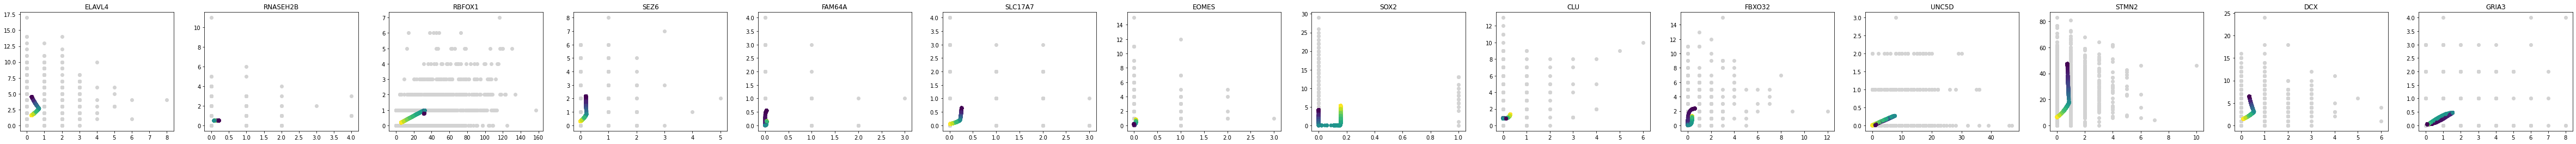

In [54]:
plot_phase(X[:,plot_idx,:],traj.thetas[0][plot_idx,:], Q, topo, tau, gene_list[plot_idx])

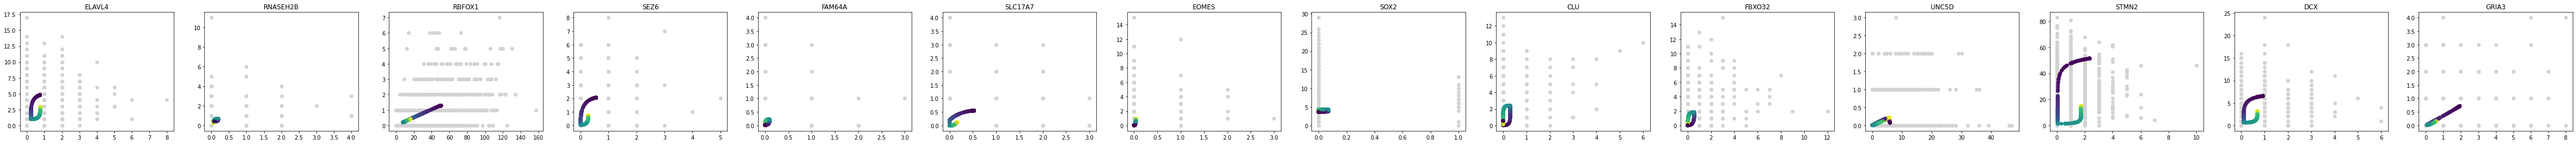

In [56]:
plot_phase(X[:,plot_idx,:],traj.thetas[2][plot_idx,:], Q, topo, tau, gene_list[plot_idx])

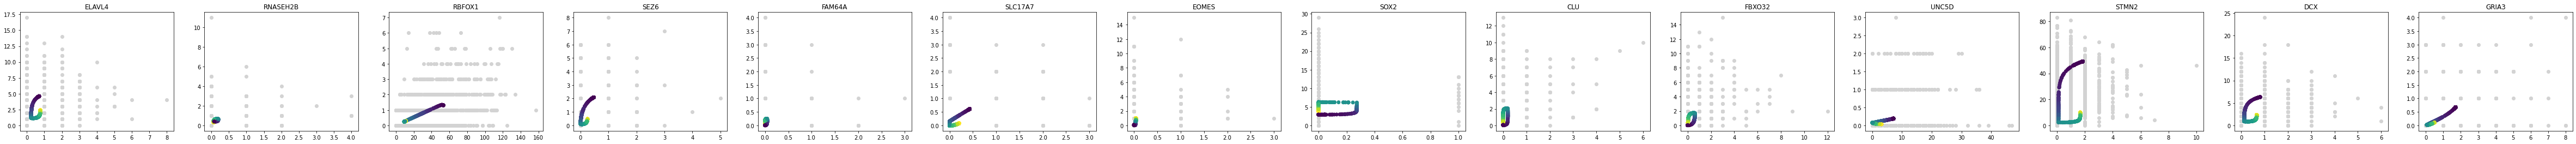

In [55]:
plot_phase(X[:,plot_idx,:],traj.thetas[3][plot_idx,:], Q, topo, tau, gene_list[plot_idx])

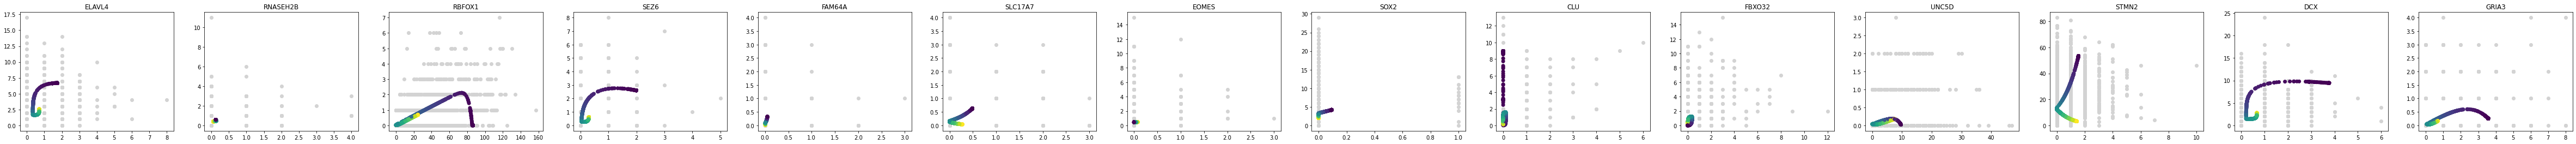

In [57]:
plot_phase(X[:,plot_idx,:],traj.thetas[4][plot_idx,:], Q, topo, tau, gene_list[plot_idx])

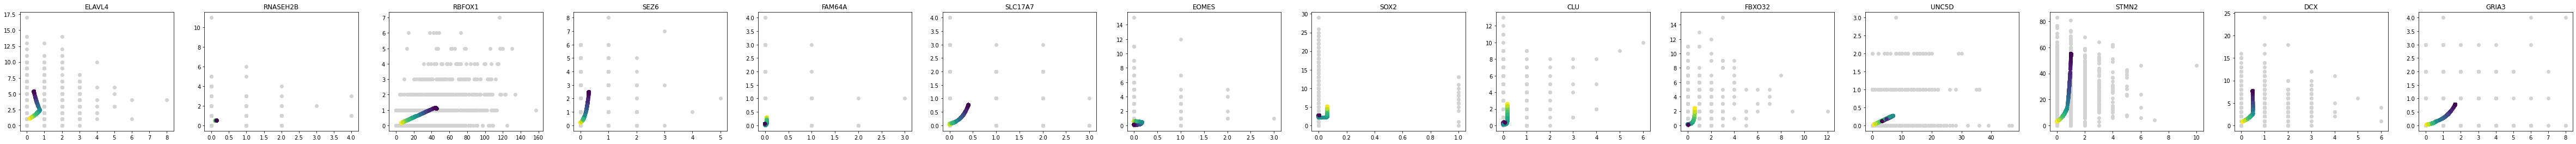

In [58]:
plot_phase(X[:,plot_idx,:],traj.thetas[5][plot_idx,:], Q, topo, tau, gene_list[plot_idx])

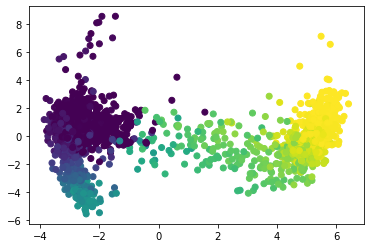

In [127]:
m=100
h=np.linspace(0,1,m)
t_1=np.sum(Q[:,0]*h[None,:],axis=1)
plt.scatter(x[:,0],x[:,1],c=t_1)

In [ ]:
import pickle
with open('../notebooks/forebrain_data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(traj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('../notebooks/forebrain_data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    traj = pickle.load(f)

In [74]:
theta = traj.theta.copy()
tau=(0,0.5,1)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X, theta=theta, parallel=True, n_threads=16)

run method fit_warm_start


 85%|████████▌ | 17/20 [00:15<00:02,  1.13it/s]Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt



KeyboardInterrupt: 

Process ForkPoolWorker-11604:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
accepts = []
diffs = []
mgene = np.arange(p)
mgene = mgene[plot_idx]
for j in mgene:
    nested_model = {j:[[0,1,-3],[-4,-4,-4]]}
    accept, diff = traj.compare_model(X, nested_model)

    accepts.append(accept)
    diffs.append(diff)


In [ ]:
accepts

In [89]:
tau=(0,0.5,1)
topo = np.array([[0,1]])
traj_ = Trajectory(topo, tau)
Q, elbo = traj_.fit(X, Q=Q0, parallel=True, n_threads=10)

run method fit_warm_start


 85%|████████▌ | 17/20 [00:23<00:04,  1.38s/it]


In [90]:
elbo

-1027.8437161157608

In [95]:
l1_ = np.sum(np.abs(traj_.theta[:,1]-traj_.theta[:,0])**2 + np.abs(traj_.theta[:,0]-traj_.theta[:,-4])**2)
l1_

2607288.00821002

In [ ]:
plot_phase(X[:,plot_idx,:],traj_.theta[plot_idx,:], Q, topo, tau, gene_list[plot_idx])

In [ ]:
m=100
h=np.linspace(0,1,m)
t_1=np.sum(Q[:,0]*h[None,:],axis=1)
plt.scatter(x[:,0],x[:,1],c=t_1)

In [ ]:
theta0 = traj_.theta.copy()
for perm in itertools.permutations(range(traj_.n_states+1)): 
    theta = theta0.copy()
    theta[:,:traj_.n_states+1] = theta0[:,np.array(perm)] 
    Q, elbo = traj_.fit(X, theta=theta, parallel=True, n_threads=10)
    print(elbo)
    plot_phase(X[:,plot_idx,:],traj_.theta[plot_idx,:], Q, topo, tau, gene_list[plot_idx])
    plt.scatter(x[:,0],x[:,1],c=np.sum(Q[:,0]*h[None,:],axis=1))

## Case 2

1110


/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/home/mffang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


Index(['ELAVL4', 'RNASEH2B', 'RBFOX1', 'SEZ6', 'FAM64A', 'SLC17A7', 'EOMES',
       'SOX2', 'CLU', 'FBXO32', 'UNC5D', 'STMN2', 'DCX', 'GRIA3'],
      dtype='object')

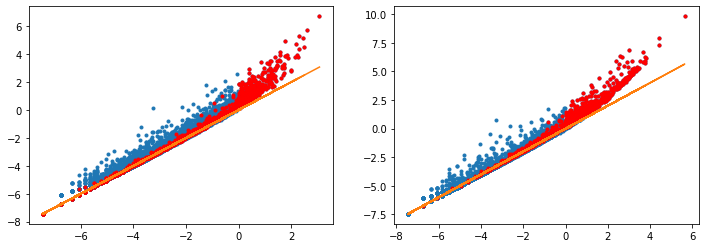

In [36]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)

idx=( ((U_mu>1) &  ((U_var/U_mu-1)/U_mu>0.1)) | ((S_mu>1) & ((S_var/S_mu-1)/S_mu>0.1)) | marker_idx )
print(np.sum(idx))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx]

In [38]:
tau=(0,0.5,1)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X, n_init=3, parallel=True, n_threads=20)

run method fit_multi_init
trial 1


 20%|██        | 4/20 [00:39<03:04, 11.55s/it]Process ForkPoolWorker-6454:
Process ForkPoolWorker-6466:
Process ForkPoolWorker-6464:
Process ForkPoolWorker-6460:
Process ForkPoolWorker-6450:
Process ForkPoolWorker-6461:
Process ForkPoolWorker-6465:
Process ForkPoolWorker-6452:
Process ForkPoolWorker-6458:
Process ForkPoolWorker-6455:
Process ForkPoolWorker-6459:
Process ForkPoolWorker-6456:
Process ForkPoolWorker-6453:
Process ForkPoolWorker-6462:
Process ForkPoolWorker-6463:
Process ForkPoolWorker-6448:
Process ForkPoolWorker-6457:
Process ForkPoolWorker-6449:
Process ForkPoolWorker-6451:
Process ForkPoolWorker-6447:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr

KeyboardInterrupt: 

In [ ]:
plt.plot(elbos)

In [ ]:
plot_phase(X[:,plot_idx,:],traj.theta[plot_idx,:], Q, topo, tau, gene_list[plot_idx])

In [ ]:
plt.plot(t_1,t_1,'black');
plt.plot(t_1,t_2,'.');

In [ ]:
plot_y(X[:,plot_idx,:],theta_hat_2[plot_idx,:], weight_2, tau, gene_list[plot_idx])

In [ ]:
plot_phase(X[:,plot_idx,:],theta_hat_2[plot_idx,:], weight_2, tau, gene_list[plot_idx])

## Case 3

In [ ]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)

idx=( ((U_mu>2) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>4) & ((S_var/S_mu-1)/S_mu>0.2)) )
print(np.sum(idx))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx]

In [ ]:
theta_hat_hist, weight_hist = traj_EM(X,tau=(0,0.5,1), weight0=weight0, epoch=20, parallel=True, n_threads=min(p,10))
theta_hat_3 = theta_hat_hist[-1]
weight_3 = weight_hist[-1]

In [ ]:
t_3=np.sum(weight_3*h[None,:],axis=1)
plt.plot(t_m,t_m,'black');
plt.plot(t_m,t_3,'.');

In [ ]:
plt.hist(t_3)

In [ ]:
plot_y(X[:,plot_idx,:],theta_hat_3[plot_idx,:], weight_3, tau, gene_list[plot_idx])

## Case 4

In [ ]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)

idx=( ((U_mu>2) &  ((U_var/U_mu-1)/U_mu>0.5)) | ((S_mu>2) & ((S_var/S_mu-1)/S_mu>0.2)) )
print(np.sum(idx))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx] 

In [ ]:
tau=(0,0.5,1)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X, m=10, n_init=100, parallel=True, n_threads=4)

In [ ]:
plot_t(Q)

In [ ]:
plt.plot(elbos)

In [ ]:
plot_phase(X[:,plot_idx,:],traj.thetas[8][plot_idx,:], Q, topo, tau, gene_list[plot_idx])

In [ ]:
tau=(0,0.5,1)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X, Q=Q0, parallel=True, n_threads=4)

In [ ]:
elbos

In [ ]:
plot_phase(X[:,plot_idx,:],traj.theta[plot_idx,:], Q, topo, tau, gene_list[plot_idx])

In [ ]:
h=np.linspace(0,1,m)
t_m=np.sum(weight_m*h[None,:],axis=1)
t_4=np.sum(weight_4*h[None,:],axis=1)
plt.plot(t_m,t_m,'black');
plt.plot(t_m,t_4,'.');

In [ ]:
plt.plot(t_3,t_4,'.');

In [ ]:
plot_y(X[:,plot_idx,:],theta_hat_4[plot_idx,:], weight_4, tau, gene_list[plot_idx])

In [ ]:
plot_phase(X[:,plot_idx],theta_hat_4[plot_idx], weight_4, tau, gene_list[plot_idx])

In [ ]:
plot_idx=np.zeros(len(gene_list),dtype=bool)
plot_idx[:1]=1

In [ ]:
plot_y(X[:,plot_idx,:],theta_hat_4[plot_idx,:], weight_4, tau, gene_list[plot_idx])

In [ ]:
plot_phase(X[:,plot_idx],theta_hat_4[plot_idx], weight_4, tau, gene_list[plot_idx])

In [ ]:
plot_theta_hat(theta_hat_4, len(tau)-1)

In [ ]:
weird = np.where(theta_hat_4[:,0]>200)[0]
weird

In [ ]:
plot_y(X[:,weird,:],theta_hat_4[weird,:], weight_4, tau, gene_list[weird])